# Galaxy Zoo Regularization Analysis (Baseline Analysis: OLS, Lasso, Ridge, Adaptive Lasso)

Statistical Inference & Modelling | Final Project

Albert Lamb, Tina Sikharulidze, Michael Duarte Gonçalves

December 2025


---

## Overview

This notebook performs a comprehensive regularization analysis on Galaxy Zoo morphology classification data. We aim to predict the probability that a galaxy is smooth (rather than featuring spiral arms or other structures) based on observable astronomical features.

### Key Objectives:
1. Apply appropriate transformations to probability targets
2. Compare multiple regularization methods (Ridge, Lasso, Adaptive Lasso)
3. Optimize hyperparameters using cross-validation
4. Identify the most important astronomical features for classification
5. Achieve robust model performance with proper train/test evaluation

## Setup and Imports

We configure our environment with all necessary packages for data processing, modeling, and visualization.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Standard library
import os
import sys
import json
import numpy as np
import pandas as pd

# Add parent directory to path for imports
sys.path.insert(0, os.path.abspath('..'))

# Collections
from collections import Counter

# Visualization
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin

# SciPy for logit transformation
from scipy.special import logit, expit

# Pre-processor
from preprocess import GalaxyZooPreprocessor

# Configuration
np.random.seed(42)
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

plt.rcParams.update({
    'figure.dpi': 150,
    'savefig.dpi': 600,
    'font.size': 12,
    'font.family': 'serif'
})
sns.set_style("whitegrid")
sns.set_palette("husl")

# Create output directories
os.makedirs("output/tables", exist_ok=True)
os.makedirs("output/figures", exist_ok=True)

print("Environment configured successfully")

Environment configured successfully


## Data Loading and Preprocessing

We load the Galaxy Zoo dataset and merge it with spectroscopic data from SDSS. The preprocessing pipeline handles:
- Missing value imputation
- Removal of non-informative features
- Merging of complementary datasets

The target variable `t01_smooth_or_features_a01_smooth_debiased` represents the debiased probability that a galaxy is smooth (0 to 1).

In [2]:
# Load raw data
gz2_sample = pd.read_csv("../data/gz2sample.csv.gz", compression="gzip")
zoo2_main = pd.read_csv("../data/zoo2MainSpecz.csv.gz", compression="gzip")

# Perform inner join to keep only matching rows
main = pd.merge(zoo2_main, gz2_sample, left_on="dr7objid", right_on="OBJID", how="inner")

# Select target variable and all sample features
selected_columns = ['t01_smooth_or_features_a01_smooth_debiased'] + gz2_sample.columns.tolist()
df = main[selected_columns]

# Instantiate and run preprocessing pipeline
preprocessor = GalaxyZooPreprocessor()
df_preprocessed = preprocessor.preprocess(df)

# Drop additional metadata columns that shouldn't be features
cols_to_drop_after = [
    "specobjid", "dr8objid", "dr7objid", "ra", "dec",
    "total_classifications", "total_votes",
]
df_preprocessed = df_preprocessed.drop(
    columns=[c for c in cols_to_drop_after if c in df_preprocessed.columns],
    errors="ignore",
)

# Save the preprocessed data
output_path = "../data/galaxy_zoo_preprocessed.csv"
os.makedirs("../data", exist_ok=True)
df_preprocessed.to_csv(output_path, index=False)

# Load preprocessed data
df = pd.read_csv('../data/galaxy_zoo_preprocessed.csv')

# Identify target columns (debiased probabilities from Galaxy Zoo)
target_cols = [c for c in df.columns if c.endswith('_debiased')]

# Select primary target variable
target_name = 't01_smooth_or_features_a01_smooth_debiased'

# Feature columns (all numeric except targets)
feature_cols = [
    col for col in df.columns
    if col not in target_cols and pd.api.types.is_numeric_dtype(df[col])
]

# Extract features and target
X = df[feature_cols].values
y = df[target_name].values

print(f"Data loaded: {df.shape[0]:,} samples, {len(feature_cols)} features")
print(f"Target: {target_name}")

Data loaded: 229,168 samples, 36 features
Target: t01_smooth_or_features_a01_smooth_debiased


## Logit Transformation

### Why Transform Probabilities?

Our target variable is a probability $p \in (0, 1)$. Linear regression assumes the response can take any value in $(-\infty, \infty)$, which violates the bounded nature of probabilities. 

The **logit transformation** maps probabilities to the real line:

$$\text{logit}(p) = \log\left(\frac{p}{1-p}\right)$$

This transformation:
- Maps $(0, 1) \rightarrow (-\infty, \infty)$
- Makes the distribution more symmetric and closer to Gaussian
- Ensures predictions can be inverted back to valid probabilities using the sigmoid function:

$$p = \text{expit}(z) = \frac{1}{1 + e^{-z}}$$

### Handling Edge Cases

Since $\log(0)$ and $\log(\infty)$ are undefined, we apply a small epsilon to clip extreme values before transformation.

In [3]:
# Apply logit transformation with epsilon for numerical stability
epsilon = 1e-7
y_clipped = np.clip(y, epsilon, 1 - epsilon)
y_logit = logit(y_clipped)

print(f"Original target range: [{y.min():.4f}, {y.max():.4f}]")
print(f"Logit-transformed range: [{y_logit.min():.4f}, {y_logit.max():.4f}]")

Original target range: [0.0000, 1.0000]
Logit-transformed range: [-16.1181, 16.1181]


### Visualizing the Transformation

We plot the original probability distribution alongside the logit-transformed distribution to verify the transformation produces a more symmetric, approximately Gaussian distribution.

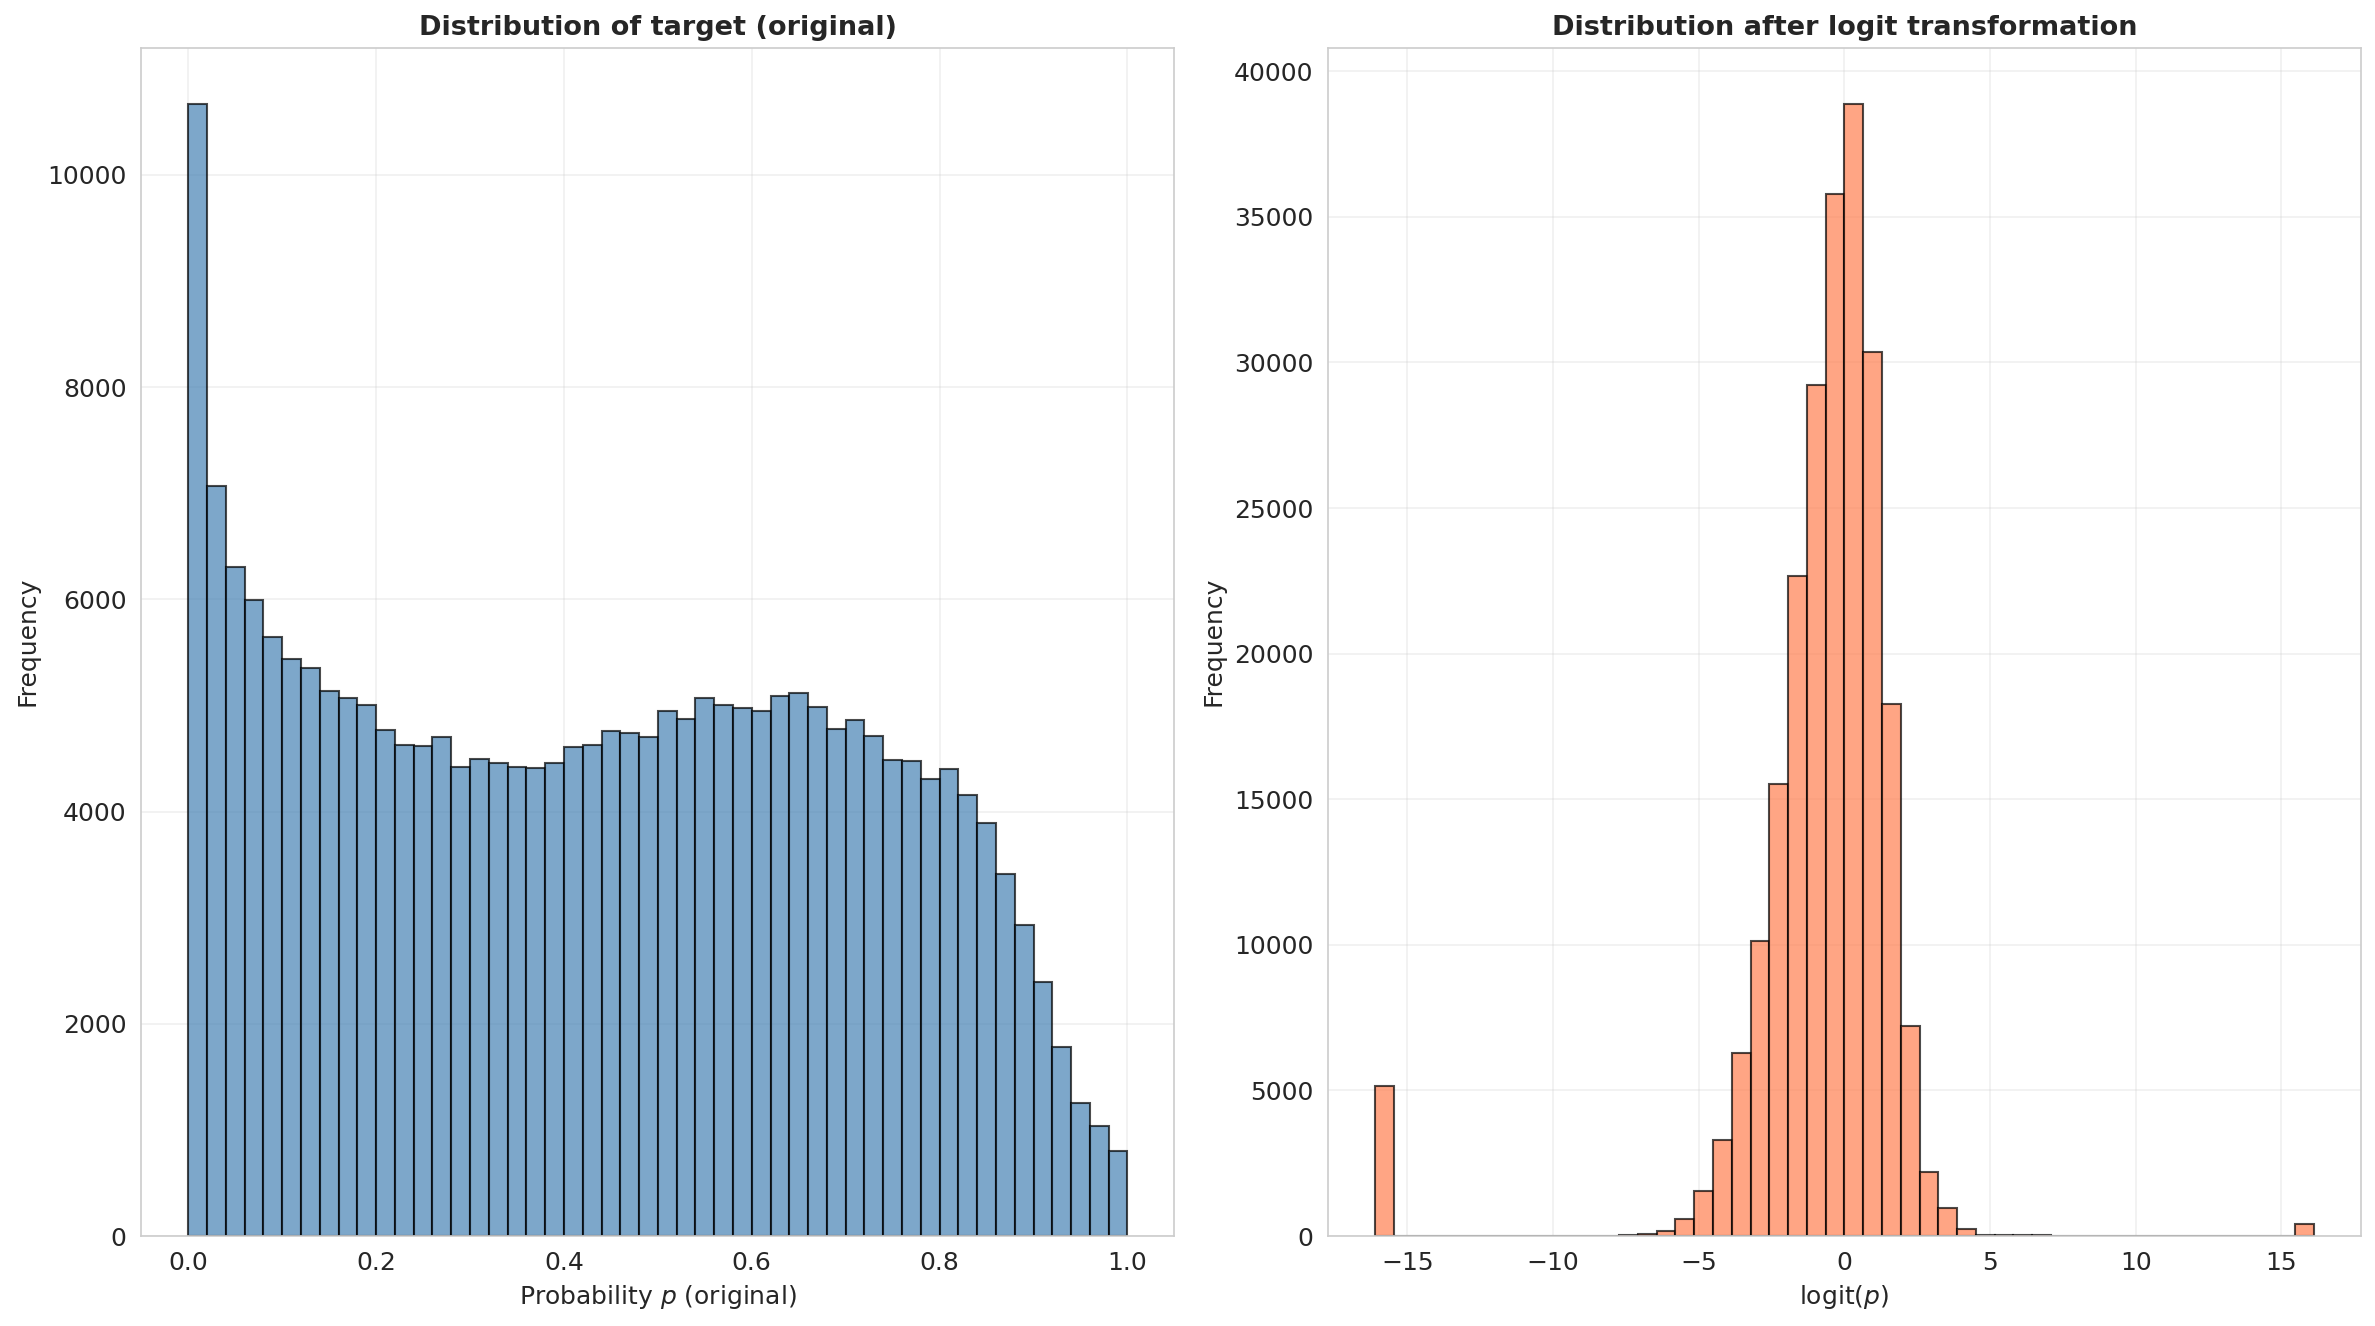

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))

# Original probabilities
axes[0].hist(y, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel(r'Probability $p$ (original)', fontsize=12)
axes[0].set_ylabel(r'Frequency', fontsize=12)
axes[0].set_title(r'Distribution of target (original)', fontsize=13, weight='bold')
axes[0].grid(alpha=0.3)

# Logit-transformed
axes[1].hist(y_logit, bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel(r'$\operatorname{logit}(p)$', fontsize=12)
axes[1].set_ylabel(r'Frequency', fontsize=12)
axes[1].set_title(r'Distribution after logit transformation', fontsize=13, weight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()



## Train/Test Split and Standardization

### Train/Test Split Strategy

We use an 80/20 train/test split to:
- Train models on 80% of the data
- Evaluate final performance on a held-out 20% test set
- Ensure unbiased estimates of model generalization

### Feature Standardization

Regularization methods (Ridge, Lasso) are sensitive to feature scales. We standardize features to have:
$$\mu = 0, \quad \sigma = 1$$

This ensures:
- Regularization penalties are applied fairly across features
- Coefficients are directly comparable in magnitude
- Numerical stability in optimization

In [5]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_logit, test_size=0.2, random_state=42
)

# Standardize features (fit on train, transform both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Also create scaled version of full dataset for analysis
X_scaled = scaler.transform(X)

print(f"Training set: {X_train_scaled.shape[0]:,} samples")
print(f"Test set: {X_test_scaled.shape[0]:,} samples")

Training set: 183,334 samples
Test set: 45,834 samples


## Baseline: Ordinary Least Squares (OLS)

We begin with **Ordinary Least Squares** regression as a baseline. OLS minimizes:

$$\min_{\beta} \|y - X\beta\|^2$$

This provides an unregularized benchmark for comparison with Ridge and Lasso methods.

In [6]:
# Fit OLS model
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_ols = ols.predict(X_train_scaled)
y_test_pred_ols = ols.predict(X_test_scaled)

# Evaluate
r2_train_ols = r2_score(y_train, y_train_pred_ols)
r2_test_ols = r2_score(y_test, y_test_pred_ols)
mse_test_ols = mean_squared_error(y_test, y_test_pred_ols)
corr_test_ols = np.corrcoef(y_test, y_test_pred_ols)[0, 1]

print("OLS Regression Results:")
print(f"Train R-squared: {r2_train_ols:.4f}")
print(f"Test R-squared:  {r2_test_ols:.4f}")
print(f"Test MSE: {mse_test_ols:.4f}")
print(f"Test Correlation: {corr_test_ols:.4f}")

OLS Regression Results:
Train R-squared: 0.3260
Test R-squared:  0.3305
Test MSE: 5.6142
Test Correlation: 0.5749


## Ridge Regression (L2 Regularization)

### Ridge Objective Function

Ridge regression adds an L2 penalty to the OLS objective:

$$\min_{\beta} \|y - X\beta\|^2 + \alpha \|\beta\|_2$$

where $\alpha \geq 0$ controls the regularization strength:
- $\alpha \rightarrow 0$: equivalent to OLS
- $\alpha \rightarrow \infty$: coefficients shrink toward zero

### Hyperparameter Selection

We use **5-fold cross-validation** to select the optimal $\alpha$ from a logarithmic grid. This ensures we evaluate performance across different regularization strengths.

In [7]:
# Define alpha grid for Ridge
alphas_ridge = np.logspace(-3, 3, 50)

# Use RidgeCV for automatic cross-validation
ridge_cv = RidgeCV(alphas=alphas_ridge, cv=5, scoring='r2')
ridge_cv.fit(X_train_scaled, y_train)

# Best alpha
best_alpha_ridge = ridge_cv.alpha_

# Predictions
y_train_pred_ridge = ridge_cv.predict(X_train_scaled)
y_test_pred_ridge = ridge_cv.predict(X_test_scaled)

# Evaluate
r2_train_ridge = r2_score(y_train, y_train_pred_ridge)
r2_test_ridge = r2_score(y_test, y_test_pred_ridge)
mse_test_ridge = mean_squared_error(y_test, y_test_pred_ridge)
corr_test_ridge = np.corrcoef(y_test, y_test_pred_ridge)[0, 1]

# Cross-validation score
cv_scores_ridge = cross_val_score(ridge_cv, X_train_scaled, y_train, cv=5, scoring='r2')

print("Ridge Regression Results:")
print(f"Best alpha: {best_alpha_ridge:.6f}")
print(f"Train R-squared: {r2_train_ridge:.4f}")
print(f"Test R-squared:  {r2_test_ridge:.4f}")
print(f"CV R-squared: {cv_scores_ridge.mean():.4f} +/- {cv_scores_ridge.std():.4f}")
print(f"Active features: {len(feature_cols)} (Ridge does not set coefficients to zero)")

Ridge Regression Results:
Best alpha: 0.039069
Train R-squared: 0.3260
Test R-squared:  0.3305
CV R-squared: 0.3255 +/- 0.0034
Active features: 36 (Ridge does not set coefficients to zero)


## Lasso Regression (L1 Regularization)

### Lasso Objective Function

Lasso regression uses an L1 penalty:

$$\min_{\beta} \|y - X\beta\|^2 + \alpha \|\beta\|_1$$

where $\|\beta\|_1 = \sum_{j=1}^p |\beta_j|$ is the L1 norm.

### Key Advantage: Sparsity

Unlike Ridge, <u>Lasso can set coefficients exactly to zero</u>, performing automatic feature selection. This is valuable when:
- We have many potentially irrelevant features
- We want an interpretable model with fewer predictors
- We suspect only a subset of features are truly important (many variables are indeed highly correlated across them)

In [8]:
# Define alpha grid for Lasso
alphas_lasso = np.logspace(-4, 0, 50)

# Use LassoCV for automatic cross-validation
lasso_cv = LassoCV(alphas=alphas_lasso, cv=5, random_state=42, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)

# Best alpha
best_alpha_lasso = lasso_cv.alpha_

# Predictions
y_train_pred_lasso = lasso_cv.predict(X_train_scaled)
y_test_pred_lasso = lasso_cv.predict(X_test_scaled)

# Evaluate
r2_train_lasso = r2_score(y_train, y_train_pred_lasso)
r2_test_lasso = r2_score(y_test, y_test_pred_lasso)
mse_test_lasso = mean_squared_error(y_test, y_test_pred_lasso)
corr_test_lasso = np.corrcoef(y_test, y_test_pred_lasso)[0, 1]

# Count non-zero coefficients
n_nonzero_lasso = np.sum(lasso_cv.coef_ != 0)

# Cross-validation score
cv_scores_lasso = cross_val_score(lasso_cv, X_train_scaled, y_train, cv=5, scoring='r2')

print("Lasso Regression Results:")
print(f"Best alpha: {best_alpha_lasso:.6f}")
print(f"Train R-squared: {r2_train_lasso:.4f}")
print(f"Test R-squared:  {r2_test_lasso:.4f}")
print(f"CV R-squared: {cv_scores_lasso.mean():.4f} +/- {cv_scores_lasso.std():.4f}")
print(f"Active features: {n_nonzero_lasso}/{len(feature_cols)}")

Lasso Regression Results:
Best alpha: 0.000100
Train R-squared: 0.3250
Test R-squared:  0.3292
CV R-squared: 0.3245 +/- 0.0033
Active features: 36/36


## Adaptive Lasso

### Motivation

Standard Lasso applies uniform penalization to all coefficients. Adaptive Lasso improves upon this by applying feature-specific penalties:

$$\min_{\beta} \|y - X\beta\|^2 + \alpha \sum_{j=1}^p w_j |\beta_j|$$

where the weights $w_j$ are derived from an initial estimate $\hat{\beta}^{\text{init}}$ (here, we use Ridge):

$$w_j = \frac{1}{|\hat{\beta}_j^{\text{init}}|^\gamma}$$

### Tuning Parameter: $\gamma$

The parameter $\gamma > 0$ controls how aggressively we penalize coefficients based on their initial estimates:
- Small coefficients get large penalties - more likely to be zeroed out
- Large coefficients get small penalties - more likely to remain




In [9]:
class AdaptiveLasso(BaseEstimator, RegressorMixin):
    """
    Adaptive Lasso regression with feature-specific penalties.
    
    Parameters
    ----------
    alpha : float
        Overall regularization strength
    gamma : float
        Exponent for adaptive weights (default=1)
    """
    def __init__(self, alpha=1.0, gamma=1.0):
        self.alpha = alpha
        self.gamma = gamma
        
    def fit(self, X, y):
        # Get initial coefficients from Ridge
        ridge_init = Ridge(alpha=1.0)
        ridge_init.fit(X, y)
        beta_init = ridge_init.coef_
        
        # Compute adaptive weights
        epsilon = 1e-8
        weights = 1.0 / (np.abs(beta_init) + epsilon) ** self.gamma
        
        # Scale features by weights and fit Lasso
        X_weighted = X / weights
        self.lasso_ = Lasso(alpha=self.alpha, max_iter=10000)
        self.lasso_.fit(X_weighted, y)
        
        # Recover original coefficients
        self.coef_ = self.lasso_.coef_ / weights
        self.intercept_ = self.lasso_.intercept_
        
        return self
    
    def predict(self, X):
        return X @ self.coef_ + self.intercept_

print("Adaptive Lasso class defined")

Adaptive Lasso class defined


### Optimizing Gamma

We perform a grid search over $\gamma \in \{1, 2, 3, 5, 10, 15, 20, 30, 40\}$ to find the optimal weighting scheme.

In [10]:
# Grid search over gamma values
gamma_values = [1.0, 2.0, 3.0, 5.0, 10.0, 15.0, 20.0, 30.0, 40.0]
gamma_results = []

for gamma in gamma_values:
    adaptive = AdaptiveLasso(alpha=best_alpha_lasso, gamma=gamma)
    adaptive.fit(X_train_scaled, y_train)
    
    # Evaluate
    y_test_pred = adaptive.predict(X_test_scaled)
    r2_test = r2_score(y_test, y_test_pred)
    n_features = np.sum(adaptive.coef_ != 0)
    
    gamma_results.append({
        'gamma': gamma,
        'r2_test': r2_test,
        'n_features': n_features
    })

df_gamma = pd.DataFrame(gamma_results)

# Select best gamma
best_gamma_idx = df_gamma['r2_test'].idxmax()
best_gamma = df_gamma.loc[best_gamma_idx, 'gamma']

print("Gamma Optimization Results:")
print(df_gamma.to_string(index=False))
print(f"\nBest gamma: {best_gamma}")

Gamma Optimization Results:
 gamma  r2_test  n_features
   1.0 0.329382          35
   2.0 0.329184          33
   3.0 0.328555          30
   5.0 0.328424          30
  10.0 0.327945          28
  15.0 0.327809          27
  20.0 0.327808          27
  30.0 0.327800          27
  40.0 0.327770          27

Best gamma: 1.0


### Final Adaptive Lasso Model

We train the final Adaptive Lasso model using the optimal $\gamma$ and evaluate its performance.

In [12]:
# Train final Adaptive Lasso with best gamma
adaptive_lasso = AdaptiveLasso(alpha=best_alpha_lasso, gamma=best_gamma)
adaptive_lasso.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_adaptive = adaptive_lasso.predict(X_train_scaled)
y_test_pred_adaptive = adaptive_lasso.predict(X_test_scaled)

# Evaluate
r2_train_adaptive = r2_score(y_train, y_train_pred_adaptive)
r2_test_adaptive = r2_score(y_test, y_test_pred_adaptive)
mse_test_adaptive = mean_squared_error(y_test, y_test_pred_adaptive)
corr_test_adaptive = np.corrcoef(y_test, y_test_pred_adaptive)[0, 1]
n_nonzero_adaptive = np.sum(adaptive_lasso.coef_ != 0)

# Cross-validation
cv_scores_adaptive = cross_val_score(
    AdaptiveLasso(alpha=best_alpha_lasso, gamma=best_gamma),
    X_train_scaled, y_train, cv=5, scoring='r2'
)

print("Adaptive Lasso Results:")
print(f"alpha: {best_alpha_lasso:.6f}")
print(f"gamma: {best_gamma}")
print(f"Train R-squared: {r2_train_adaptive:.4f}")
print(f"Test R-squared:  {r2_test_adaptive:.4f}")
print(f"CV R-squared: {cv_scores_adaptive.mean():.4f} +/- {cv_scores_adaptive.std():.4f}")
print(f"Active features: {n_nonzero_adaptive}/{len(feature_cols)}")

Adaptive Lasso Results:
alpha: 0.000100
gamma: 1.0
Train R-squared: 0.3251
Test R-squared:  0.3294
CV R-squared: 0.3246 +/- 0.0033
Active features: 35/36


## Methods Comparison

We compile all results into a comprehensive comparison table to identify the best-performing method.

In [13]:
# Compile results
methods_results = [
    {
        'method': 'OLS',
        'alpha': 0.0,
        'gamma': None,
        'r2_train': r2_train_ols,
        'r2_test': r2_test_ols,
        'r2_cv_mean': np.nan,
        'r2_cv_std': np.nan,
        'correlation_test': corr_test_ols,
        'mse_test': mse_test_ols,
        'n_features': len(feature_cols)
    },
    {
        'method': 'Ridge',
        'alpha': best_alpha_ridge,
        'gamma': None,
        'r2_train': r2_train_ridge,
        'r2_test': r2_test_ridge,
        'r2_cv_mean': cv_scores_ridge.mean(),
        'r2_cv_std': cv_scores_ridge.std(),
        'correlation_test': corr_test_ridge,
        'mse_test': mse_test_ridge,
        'n_features': len(feature_cols)
    },
    {
        'method': 'Lasso',
        'alpha': best_alpha_lasso,
        'gamma': None,
        'r2_train': r2_train_lasso,
        'r2_test': r2_test_lasso,
        'r2_cv_mean': cv_scores_lasso.mean(),
        'r2_cv_std': cv_scores_lasso.std(),
        'correlation_test': corr_test_lasso,
        'mse_test': mse_test_lasso,
        'n_features': n_nonzero_lasso
    },
    {
        'method': 'Adaptive Lasso',
        'alpha': best_alpha_lasso,
        'gamma': best_gamma,
        'r2_train': r2_train_adaptive,
        'r2_test': r2_test_adaptive,
        'r2_cv_mean': cv_scores_adaptive.mean(),
        'r2_cv_std': cv_scores_adaptive.std(),
        'correlation_test': corr_test_adaptive,
        'mse_test': mse_test_adaptive,
        'n_features': n_nonzero_adaptive
    }
]

df_methods = pd.DataFrame(methods_results)

print("\nMethods Comparison:")
print(df_methods.to_string(index=False))


# Save table
df_methods.to_csv('output/tables/01_methods_comparison.csv', index=False)
print("\nSaved: output/tables/01_methods_comparison.csv")


Methods Comparison:
        method    alpha  gamma  r2_train  r2_test  r2_cv_mean  r2_cv_std  correlation_test  mse_test  n_features
           OLS 0.000000    NaN  0.326050 0.330499         NaN        NaN          0.574895  5.614239          36
         Ridge 0.039069    NaN  0.326049 0.330496    0.325509   0.003386          0.574892  5.614265          36
         Lasso 0.000100    NaN  0.325001 0.329205    0.324501   0.003337          0.573779  5.625093          36
Adaptive Lasso 0.000100    1.0  0.325137 0.329382    0.324640   0.003298          0.573929  5.623607          35

Saved: output/tables/01_methods_comparison.csv


### Visualization: Regularization Methods Comparison Across Alpha Values

We create a comprehensive visualization comparing Ridge, Lasso, and Adaptive Lasso across the entire regularization path. This multi-panel analysis reveals fundamental differences in how these methods balance:
- Predictive performance (Test $R^2$)
- Feature selection (sparsity)
- Prediction error (MSE)

#### Key Comparisons:

1. Test $R^2$ vs $\alpha$: Shows how predictive performance changes with regularization strength for each method
2. Feature Selection vs Alpha: Demonstrates the sparsity-inducing properties of L1-based methods
   - Ridge maintains all features regardless of $\alpha$
   - Lasso progressively eliminates features as $\alpha$ increases
   - Adaptive Lasso (fixed $\gamma$=1) performs more targeted feature elimination
3. MSE vs Alpha: Tracks prediction error across the regularization path
4. Sparsity-Performance Trade-off: The critical comparison showing which method achieves the best $R^2$ with the fewest features

This visualization provides empirical justification for method selection by directly comparing their behavior across identical regularization strengths.

Comparing Ridge, Lasso, and Adaptive Lasso across alpha values...
Adaptive Lasso uses gamma = 1.0
Testing 30 alpha values

Analysis complete



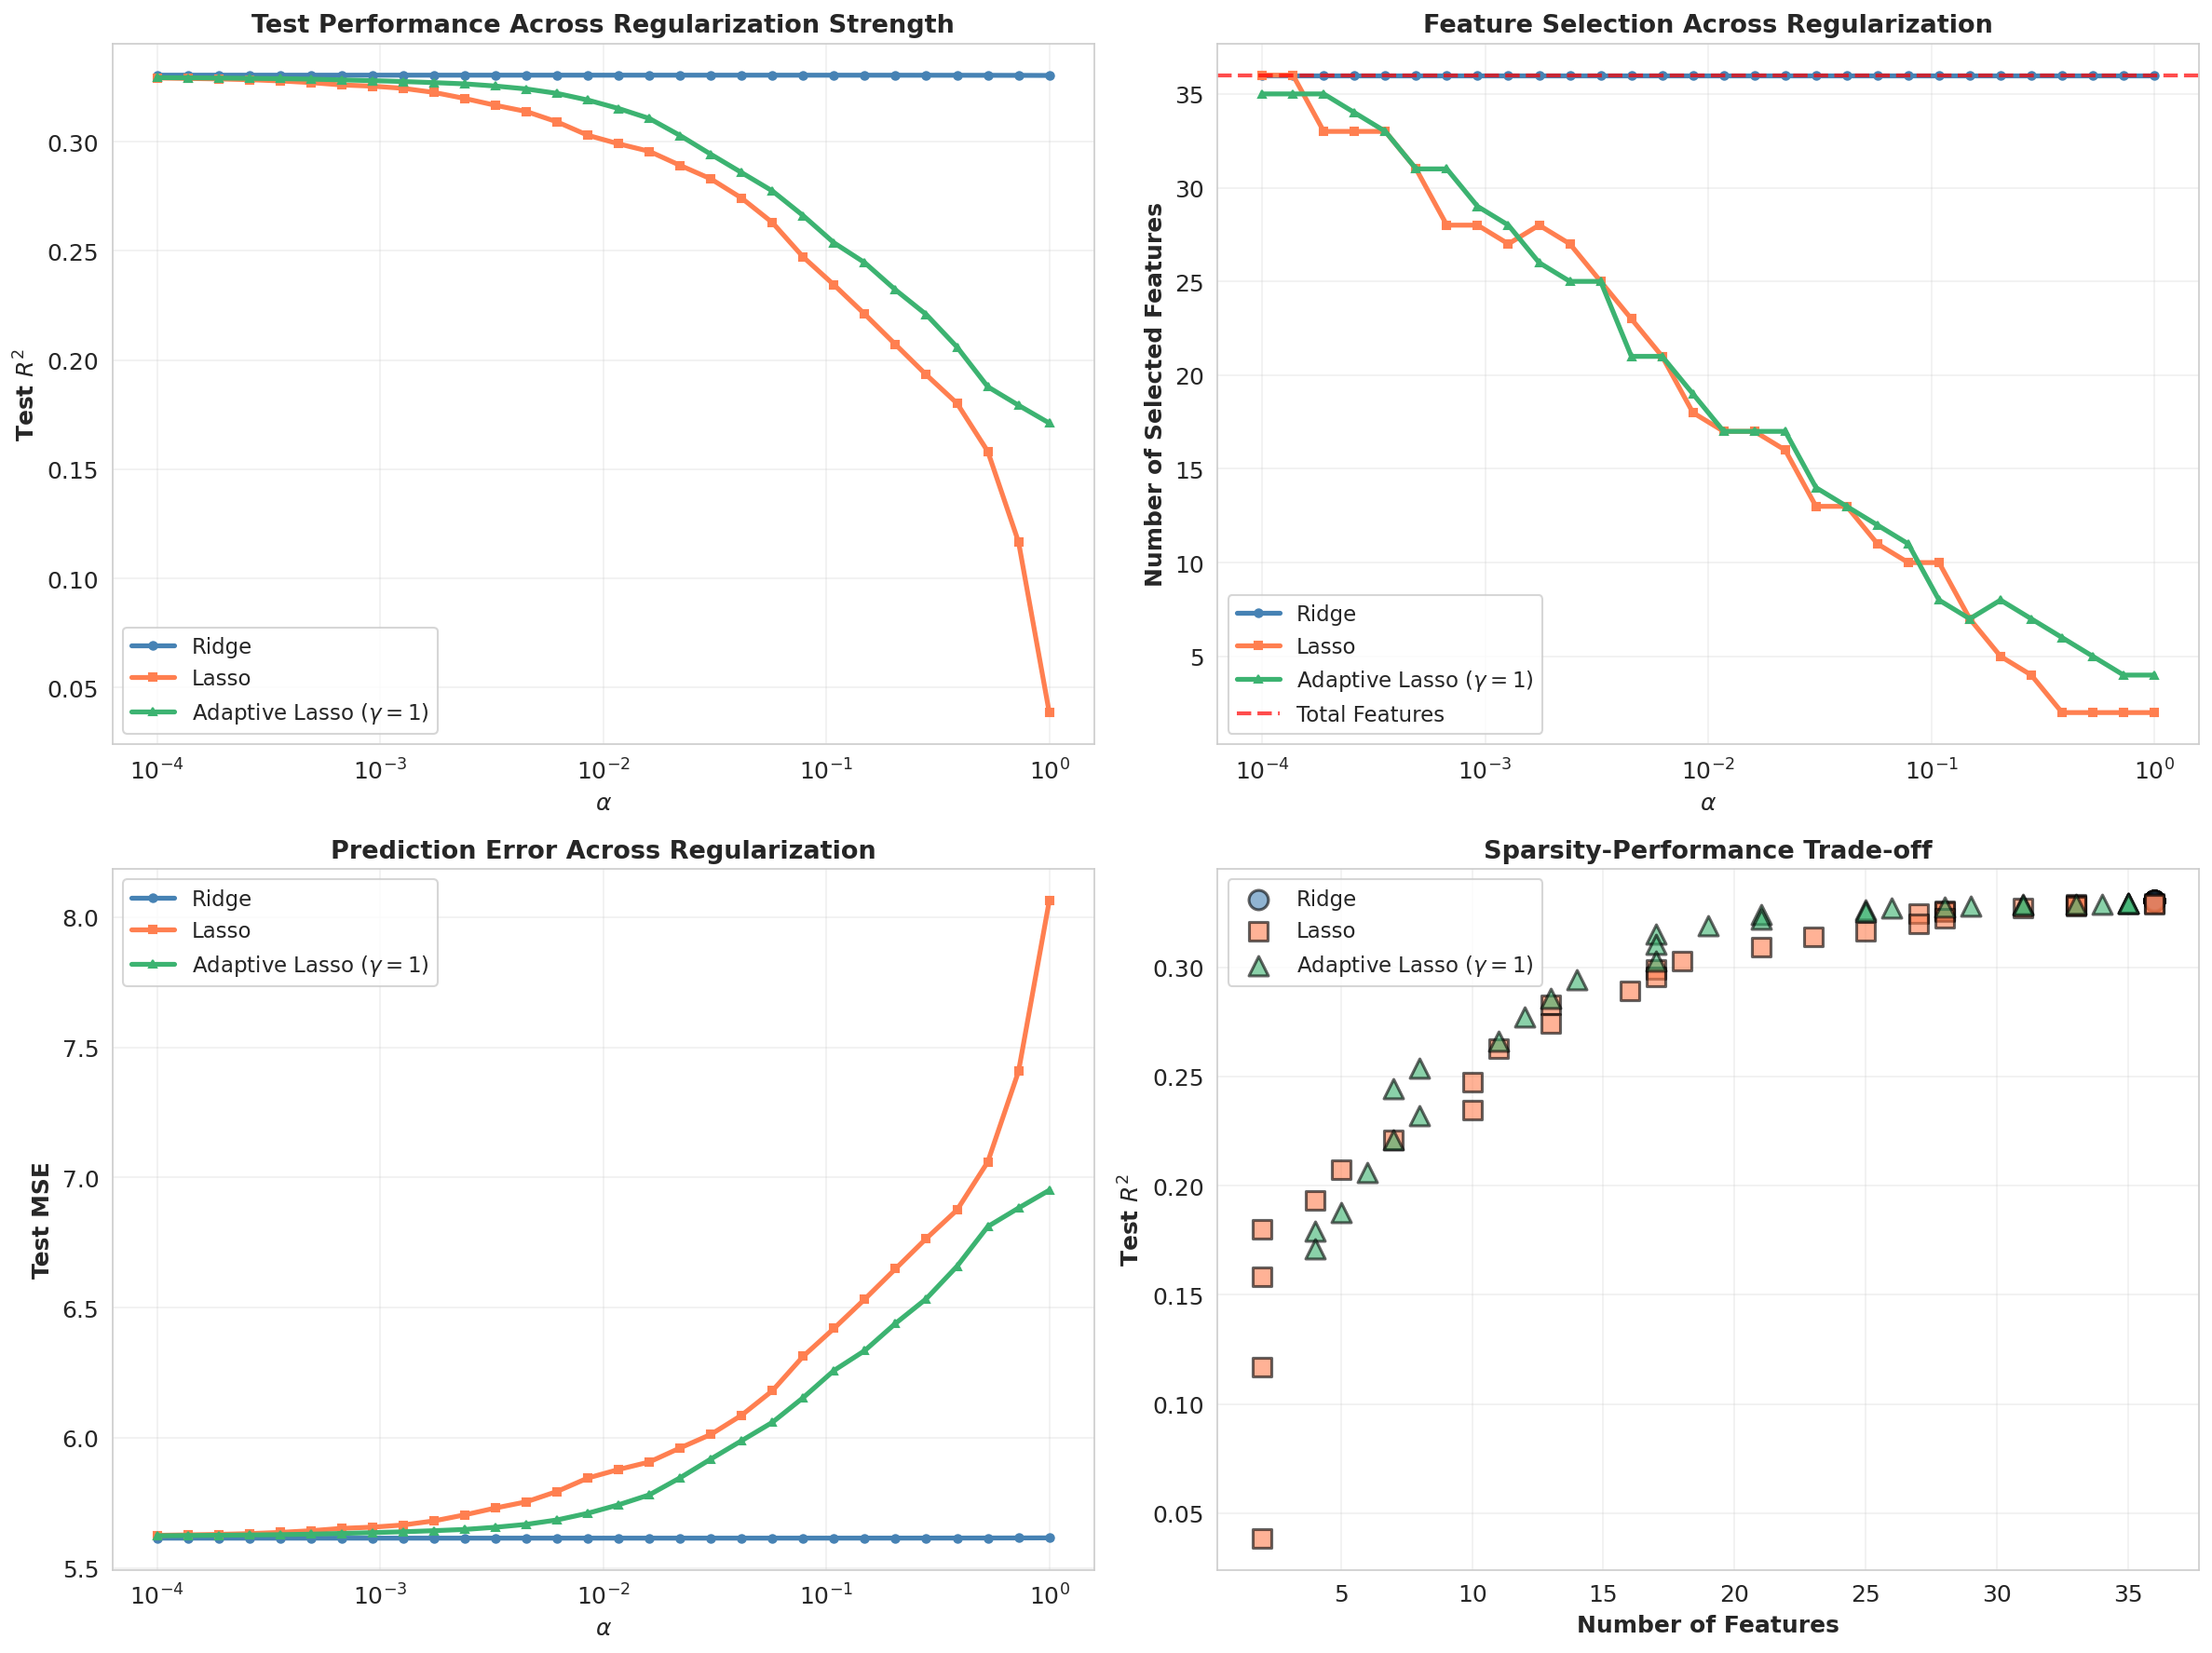

Saved: output/figures/01_regularization_methods_comparison.png
Saved: output/tables/02_methods_alpha_comparison.csv


In [14]:
# Comprehensive Comparison: Ridge vs Lasso vs Adaptive Lasso Across Alpha Values

# Define alpha values to explore
alphas_comparison = np.logspace(-4, 0, 30)
gamma_fixed = 1.0

print("Comparing Ridge, Lasso, and Adaptive Lasso across alpha values...")
print(f"Adaptive Lasso uses gamma = {gamma_fixed}")
print(f"Testing {len(alphas_comparison)} alpha values\n")

# Storage for results
results = {'Ridge': [], 'Lasso': [], 'Adaptive Lasso': []}

for alpha in alphas_comparison:
    # Ridge
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    y_pred_ridge = ridge.predict(X_test_scaled)
    
    results['Ridge'].append({
        'alpha': alpha,
        'r2_test': r2_score(y_test, y_pred_ridge),
        'mse_test': mean_squared_error(y_test, y_pred_ridge),
        'n_features': len(feature_cols)
    })
    
    # Lasso
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    y_pred_lasso = lasso.predict(X_test_scaled)
    
    results['Lasso'].append({
        'alpha': alpha,
        'r2_test': r2_score(y_test, y_pred_lasso),
        'mse_test': mean_squared_error(y_test, y_pred_lasso),
        'n_features': np.sum(lasso.coef_ != 0)
    })
    
    # Adaptive Lasso
    adaptive = AdaptiveLasso(alpha=alpha, gamma=gamma_fixed)
    adaptive.fit(X_train_scaled, y_train)
    y_pred_adaptive = adaptive.predict(X_test_scaled)
    
    results['Adaptive Lasso'].append({
        'alpha': alpha,
        'r2_test': r2_score(y_test, y_pred_adaptive),
        'mse_test': mean_squared_error(y_test, y_pred_adaptive),
        'n_features': np.sum(adaptive.coef_ != 0)
    })

# Convert to DataFrames
df_ridge = pd.DataFrame(results['Ridge'])
df_lasso = pd.DataFrame(results['Lasso'])
df_adaptive = pd.DataFrame(results['Adaptive Lasso'])

print("Analysis complete\n")

# Create comprehensive comparison plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Method configurations
methods = {
    'Ridge': {'data': df_ridge, 'color': 'steelblue', 'marker': 'o'},
    'Lasso': {'data': df_lasso, 'color': 'coral', 'marker': 's'},
    r'Adaptive Lasso ($\gamma=1$)': {'data': df_adaptive, 'color': 'mediumseagreen', 'marker': '^'}
}

# Plot 1: Test R² vs Alpha
for method_name, config in methods.items():
    df = config['data']
    axes[0, 0].plot(df['alpha'], df['r2_test'], 
                    marker=config['marker'], linewidth=2.5, label=method_name, 
                    color=config['color'], markersize=4)

axes[0, 0].set_xlabel(r'$\alpha$', fontsize=12, weight='bold')
axes[0, 0].set_ylabel(r'Test $R^2$', fontsize=12, weight='bold')
axes[0, 0].set_title('Test Performance Across Regularization Strength', fontsize=13, weight='bold')
axes[0, 0].set_xscale('log')
axes[0, 0].legend(fontsize=11, loc='best')
axes[0, 0].grid(alpha=0.3)

# Plot 2: Number of Features vs Alpha
for method_name, config in methods.items():
    df = config['data']
    axes[0, 1].plot(df['alpha'], df['n_features'], 
                    marker=config['marker'], linewidth=2.5, label=method_name,
                    color=config['color'], markersize=4)

axes[0, 1].axhline(len(feature_cols), color='red', linestyle='--', 
                   linewidth=2, alpha=0.7, label='Total Features')
axes[0, 1].set_xlabel(r'$\alpha$', fontsize=12, weight='bold')
axes[0, 1].set_ylabel('Number of Selected Features', fontsize=12, weight='bold')
axes[0, 1].set_title('Feature Selection Across Regularization', fontsize=13, weight='bold')
axes[0, 1].set_xscale('log')
axes[0, 1].legend(fontsize=11, loc='best')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Test MSE vs Alpha
for method_name, config in methods.items():
    df = config['data']
    axes[1, 0].plot(df['alpha'], df['mse_test'], 
                    marker=config['marker'], linewidth=2.5, label=method_name,
                    color=config['color'], markersize=4)

axes[1, 0].set_xlabel(r'$\alpha$', fontsize=12, weight='bold')
axes[1, 0].set_ylabel('Test MSE', fontsize=12, weight='bold')
axes[1, 0].set_title('Prediction Error Across Regularization', fontsize=13, weight='bold')
axes[1, 0].set_xscale('log')
axes[1, 0].legend(fontsize=11, loc='best')
axes[1, 0].grid(alpha=0.3)

# Plot 4: Sparsity vs Performance Trade-off
for method_name, config in methods.items():
    df = config['data']
    axes[1, 1].scatter(df['n_features'], df['r2_test'], 
                       s=100, alpha=0.6, label=method_name, 
                       color=config['color'], marker=config['marker'],
                       edgecolors='black', linewidth=1.5)

axes[1, 1].set_xlabel('Number of Features', fontsize=12, weight='bold')
axes[1, 1].set_ylabel(r'Test $R^2$', fontsize=12, weight='bold')
axes[1, 1].set_title('Sparsity-Performance Trade-off', fontsize=13, weight='bold')
axes[1, 1].legend(fontsize=11, loc='best')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('output/figures/01_regularization_methods_comparison.png')
plt.show()

print("Saved: output/figures/01_regularization_methods_comparison.png")

# Save comparison data
df_ridge['method'] = 'Ridge'
df_lasso['method'] = 'Lasso'
df_adaptive['method'] = 'Adaptive Lasso'

df_comparison_all = pd.concat([df_ridge, df_lasso, df_adaptive], ignore_index=True)
df_comparison_all.to_csv('output/tables/02_methods_alpha_comparison.csv', index=False)

print("Saved: output/tables/02_methods_alpha_comparison.csv")

## Alpha Regularization Path Analysis

### Understanding the Regularization Path

We examine how model performance varies as we sweep through different values of the regularization parameter $\alpha$. This helps us understand:
- The trade-off between model complexity and generalization
- The stability of hyperparameter selection
- Whether we've explored a sufficient range of $\alpha$ values

In [15]:
# Alpha sweep for Lasso
alphas_sweep = np.logspace(-4, 0, 30)
lasso_sweep_results = []

for alpha in alphas_sweep:
    lasso_temp = Lasso(alpha=alpha, max_iter=10000)
    lasso_temp.fit(X_train_scaled, y_train)
    
    y_test_pred = lasso_temp.predict(X_test_scaled)
    r2_test = r2_score(y_test, y_test_pred)
    n_features = np.sum(lasso_temp.coef_ != 0)
    
    lasso_sweep_results.append({
        'alpha': alpha,
        'r2_test': r2_test,
        'n_features': n_features
    })

df_lasso_alpha = pd.DataFrame(lasso_sweep_results)

# Alpha sweep for Adaptive Lasso
adaptive_sweep_results = []

for alpha in alphas_sweep:
    adaptive_temp = AdaptiveLasso(alpha=alpha, gamma=best_gamma)
    adaptive_temp.fit(X_train_scaled, y_train)
    
    y_test_pred = adaptive_temp.predict(X_test_scaled)
    r2_test = r2_score(y_test, y_test_pred)
    n_features = np.sum(adaptive_temp.coef_ != 0)
    
    adaptive_sweep_results.append({
        'alpha': alpha,
        'r2_test': r2_test,
        'n_features': n_features
    })

df_adaptive_alpha = pd.DataFrame(adaptive_sweep_results)

# Save sweep results
df_lasso_alpha.to_csv('output/tables/03_lasso_alpha_sweep.csv', index=False)
df_adaptive_alpha.to_csv('output/tables/04_adaptive_alpha_sweep.csv', index=False)

print("Alpha sweep complete")
print(f"Saved: output/tables/03_lasso_alpha_sweep.csv")
print(f"Saved: output/tables/04_adaptive_alpha_sweep.csv")

Alpha sweep complete
Saved: output/tables/03_lasso_alpha_sweep.csv
Saved: output/tables/04_adaptive_alpha_sweep.csv


## Gamma Effects Visualization

We visualize how the choice of $\gamma$ in Adaptive Lasso affects both predictive performance and feature selection.

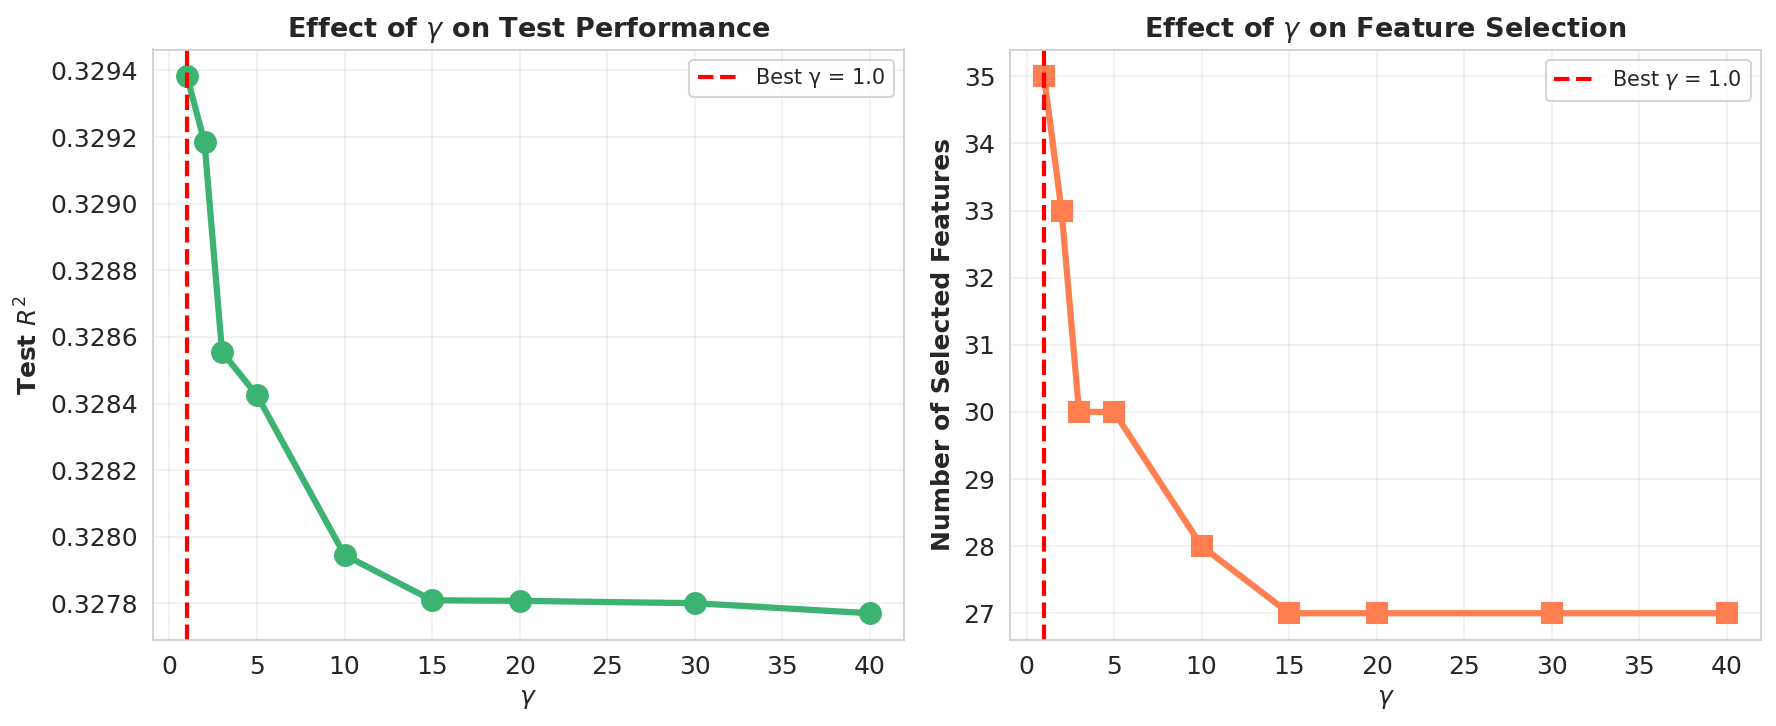

Saved: output/tables/05_gamma_sweep.csv
Saved: output/figures/02_gamma_effects.png


In [16]:
# Save gamma results
df_gamma.to_csv('output/tables/05_gamma_sweep.csv', index=False)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Test R² vs Gamma
axes[0].plot(df_gamma['gamma'], df_gamma['r2_test'], 
             marker='o', markersize=10, linewidth=3, color='mediumseagreen')
axes[0].axvline(best_gamma, color='red', linestyle='--', linewidth=2, label=f'Best γ = {best_gamma}')
axes[0].set_xlabel(r'$\gamma$', fontsize=12, weight='bold')
axes[0].set_ylabel(r'Test $R^2$', fontsize=12, weight='bold')
axes[0].set_title(r'Effect of $\gamma$ on Test Performance', fontsize=13, weight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Number of Features vs Gamma
axes[1].plot(df_gamma['gamma'], df_gamma['n_features'], 
             marker='s', markersize=10, linewidth=3, color='coral')
axes[1].axvline(best_gamma, color='red', linestyle='--', linewidth=2, label=r'Best $\gamma$ = ' + f'{best_gamma:.1f}')
axes[1].set_xlabel(r'$\gamma$', fontsize=12, weight='bold')
axes[1].set_ylabel('Number of Selected Features', fontsize=12, weight='bold')
axes[1].set_title(r'Effect of $\gamma$ on Feature Selection', fontsize=13, weight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('output/figures/02_gamma_effects.png')
plt.show()

print("Saved: output/tables/05_gamma_sweep.csv")
print("Saved: output/figures/02_gamma_effects.png")

## Feature Importance Analysis

### Selected Features Across Different Alpha Values

We systematically explore how feature selection changes across different regularization strengths ($\alpha$) while keeping $\gamma = 1$ fixed. This analysis reveals:
- Which features are consistently selected (robust across $\alpha$ values)
- How coefficient magnitudes change with regularization strength
- The trade-off between sparsity and model complexity

We create an Excel file with separate sheets for each $\alpha$ value, making it easy to compare feature selection across the regularization path.

In [17]:
# Feature Selection Across Different Alpha Values (fixed gamma = 1)

# Define alpha values to explore (spanning weak to strong regularization)
alphas_to_export = np.logspace(-4, 0, 10)  # 10 alpha values from 0.0001 to 1.0 (aka logspace)

# Fixed gamma value
gamma_fixed = 1.0

print("Extracting selected features across different alpha values...")
print(f"Alpha range: [{alphas_to_export.min():.6f}, {alphas_to_export.max():.6f}]\n")

# Create Excel writer
excel_path = 'output/tables/06_selected_features_by_alpha.xlsx'
with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    
    # Create a summary sheet
    summary_data = []
    
    for alpha in alphas_to_export:
        # Fit Adaptive Lasso with current alpha
        adaptive_temp = AdaptiveLasso(alpha=alpha, gamma=gamma_fixed)
        adaptive_temp.fit(X_train_scaled, y_train)
        
        # Extract non-zero coefficients
        selected_indices = np.where(adaptive_temp.coef_ != 0)[0]
        selected_features_temp = np.array(feature_cols)[selected_indices]
        selected_coefs_temp = adaptive_temp.coef_[selected_indices]
        
        # Create DataFrame for this alpha
        df_features_alpha = pd.DataFrame({
            'feature': selected_features_temp,
            'coefficient': selected_coefs_temp,
            'abs_coefficient': np.abs(selected_coefs_temp)
        }).sort_values('abs_coefficient', ascending=False)
        
        # Create sheet name (Excel has 31 char limit)
        sheet_name = f'alpha_{alpha:.6f}'[:31]
        
        # Write to Excel sheet
        df_features_alpha.to_excel(writer, sheet_name=sheet_name, index=False)
        
        # Add to summary
        y_test_pred = adaptive_temp.predict(X_test_scaled)
        r2_test = r2_score(y_test, y_test_pred)
        
        summary_data.append({
            'alpha': alpha,
            'n_features_selected': len(selected_features_temp),
            'r2_test': r2_test,
            'sheet_name': sheet_name
        })
        
        print(f"alpha = {alpha:.6f}: {len(selected_features_temp):2d} features selected, R-squared = {r2_test:.4f}")
    
    # Create summary sheet
    df_summary = pd.DataFrame(summary_data)
    df_summary.to_excel(writer, sheet_name='Summary', index=False)

print(f"\nSaved: {excel_path}")

# Also extract features for the optimal alpha (for visualization)
selected_indices = np.where(adaptive_lasso.coef_ != 0)[0]
selected_features = np.array(feature_cols)[selected_indices]
selected_coefs = adaptive_lasso.coef_[selected_indices]

df_features = pd.DataFrame({
    'feature': selected_features,
    'coefficient': selected_coefs,
    'abs_coefficient': np.abs(selected_coefs)
}).sort_values('abs_coefficient', ascending=False)

# Save CSV for the optimal alpha
df_features.to_csv('output/tables/07_selected_features_optimal_alpha.csv', index=False)

print(f"\nSaved: output/tables/07_selected_features_optimal_alpha.csv")
print(df_features.head(10).to_string(index=False))

Extracting selected features across different alpha values...
Alpha range: [0.000100, 1.000000]

alpha = 0.000100: 35 features selected, R-squared = 0.3294
alpha = 0.000278: 33 features selected, R-squared = 0.3290
alpha = 0.000774: 31 features selected, R-squared = 0.3281
alpha = 0.002154: 25 features selected, R-squared = 0.3267
alpha = 0.005995: 21 features selected, R-squared = 0.3224
alpha = 0.016681: 17 features selected, R-squared = 0.3100
alpha = 0.046416: 13 features selected, R-squared = 0.2821
alpha = 0.129155:  8 features selected, R-squared = 0.2489
alpha = 0.359381:  6 features selected, R-squared = 0.2101
alpha = 1.000000:  4 features selected, R-squared = 0.1711

Saved: output/tables/06_selected_features_by_alpha.xlsx

Saved: output/tables/07_selected_features_optimal_alpha.csv
           feature  coefficient  abs_coefficient
       PETROMAG_MR     9.106804         9.106804
LOG_PETROMAGERR_MZ     7.400706         7.400706
 LOG_PETROMAGERR_Z    -7.347744         7.347744

### Visualization: Feature Importance

We create a bar plot showing the coefficients of selected features, color-coded by sign (positive/negative influence).

Generating feature importance plots for different alpha values...

alpha = 0.000100: 35 features
alpha = 0.000278: 33 features
alpha = 0.000774: 31 features
alpha = 0.002154: 25 features
alpha = 0.005995: 21 features
alpha = 0.016681: 17 features
alpha = 0.046416: 13 features
alpha = 0.129155:  8 features
alpha = 0.359381:  6 features
alpha = 1.000000:  4 features


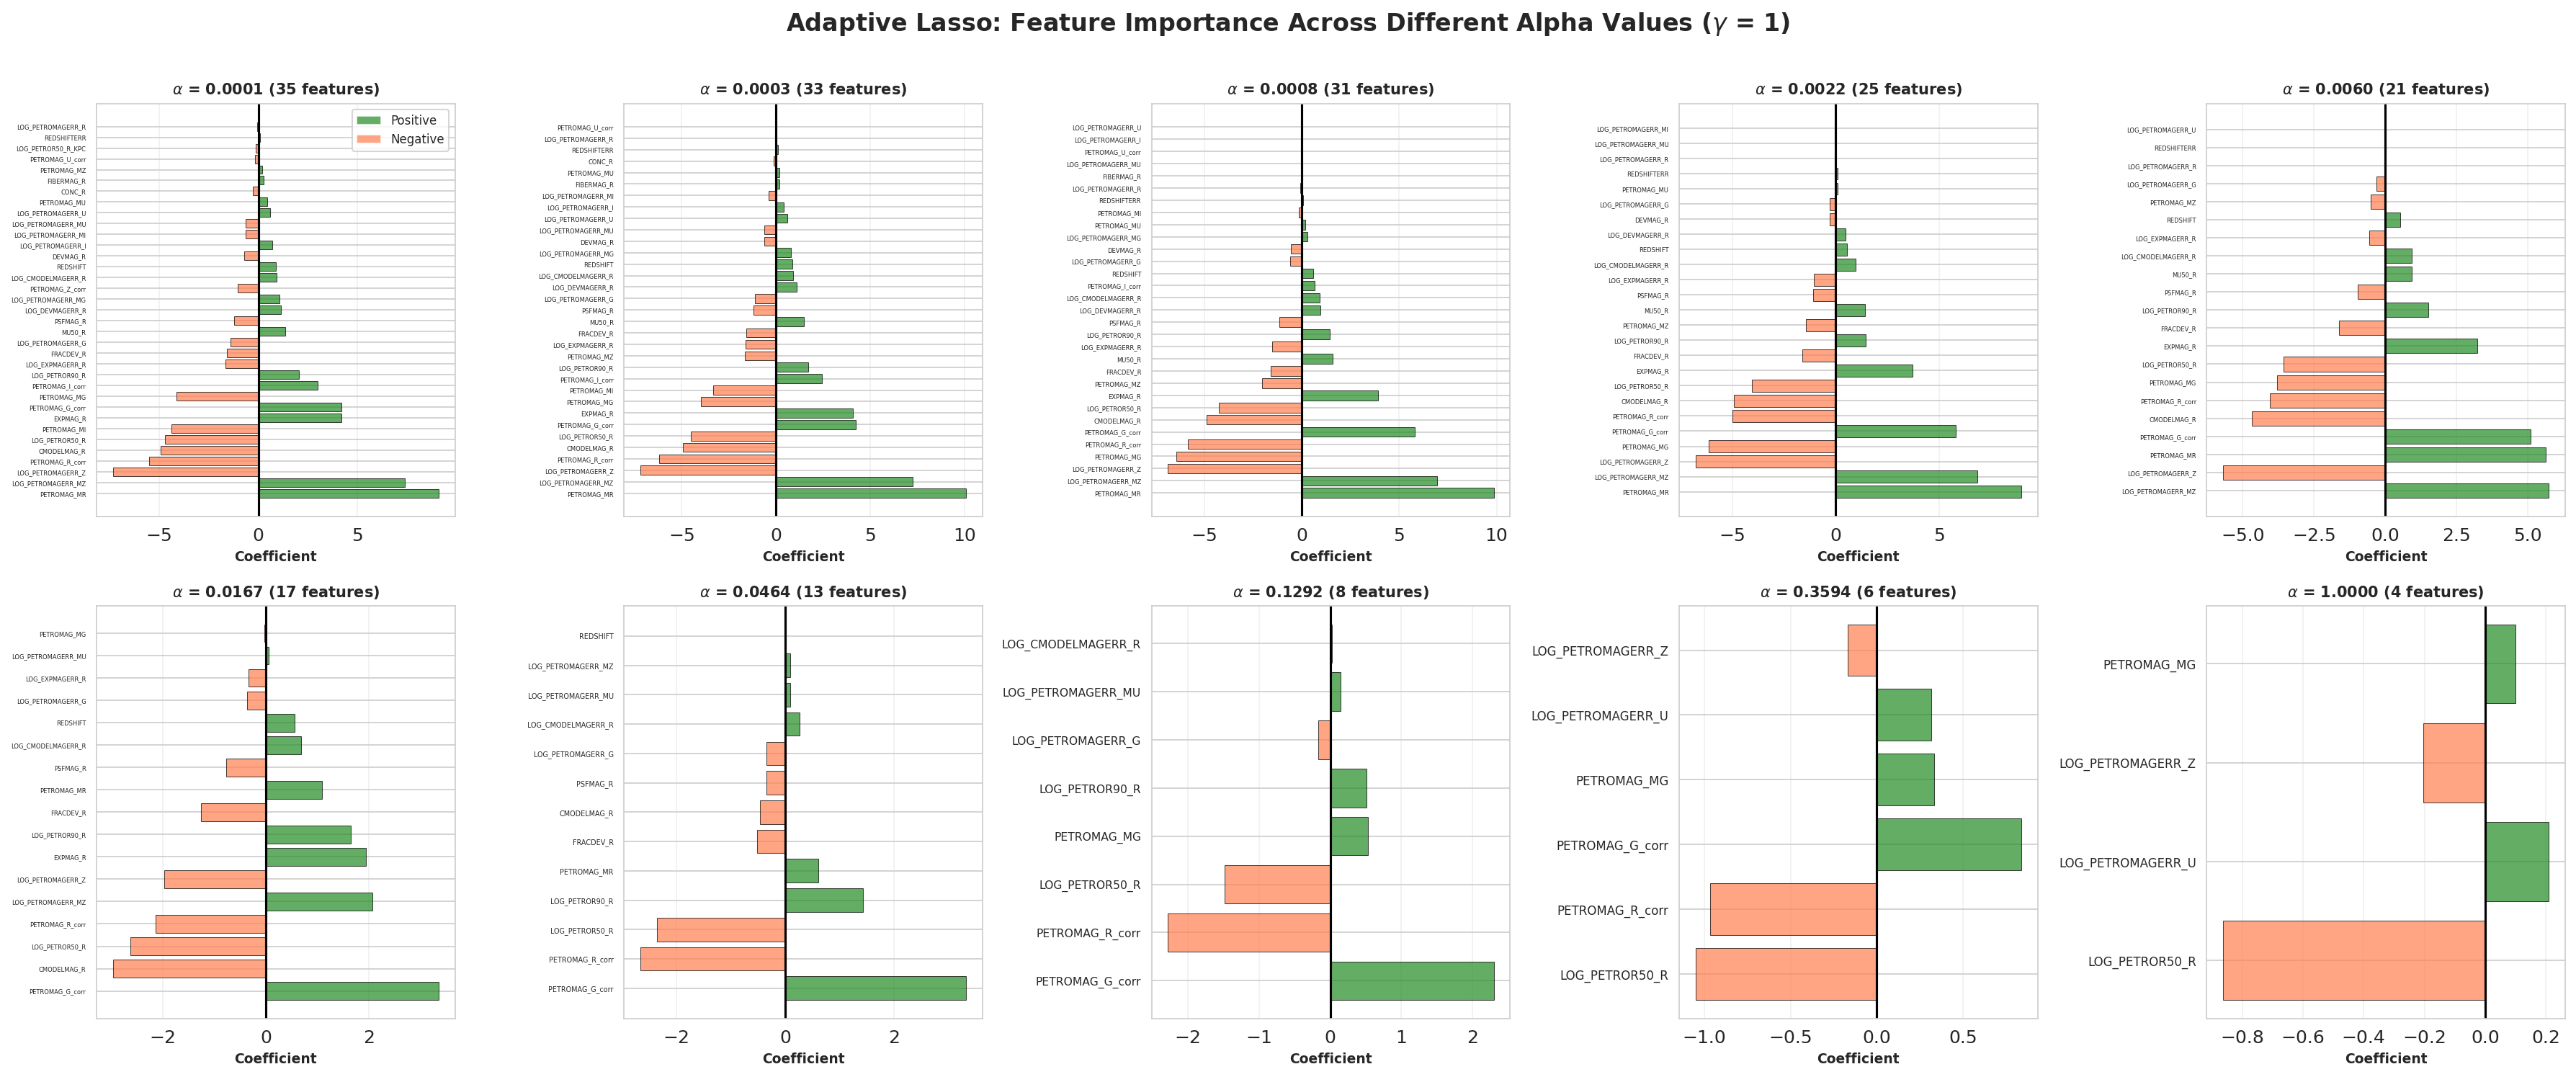


Saved: output/figures/03_feature_importance_alpha_sweep.png


In [19]:
# Define alpha values to explore
alphas_to_plot = np.logspace(-4, 0, 10)  # 10 alpha values from 0.0001 to 1.0
gamma_fixed = 1.0

# Determine grid layout (2 rows x 5 columns for 10 plots)
n_rows, n_cols = 2, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 10))
axes = axes.flatten()

print("Generating feature importance plots for different alpha values...\n")

for idx, alpha in enumerate(alphas_to_plot):
    # Fit Adaptive Lasso with current alpha
    adaptive_temp = AdaptiveLasso(alpha=alpha, gamma=gamma_fixed)
    adaptive_temp.fit(X_train_scaled, y_train)
    
    # Extract non-zero coefficients
    selected_indices = np.where(adaptive_temp.coef_ != 0)[0]
    selected_features_temp = np.array(feature_cols)[selected_indices]
    selected_coefs_temp = adaptive_temp.coef_[selected_indices]
    
    # Create DataFrame for this alpha
    df_features_alpha = pd.DataFrame({
        'feature': selected_features_temp,
        'coefficient': selected_coefs_temp,
        'abs_coefficient': np.abs(selected_coefs_temp)
    }).sort_values('abs_coefficient', ascending=False)
    
    # Get current axis
    ax = axes[idx]
    
    # Determine colors based on sign
    colors_bar = ['forestgreen' if c > 0 else 'coral' for c in df_features_alpha['coefficient']]
    
    # Horizontal bar plot
    y_pos = np.arange(len(df_features_alpha))
    ax.barh(y_pos, df_features_alpha['coefficient'], color=colors_bar, alpha=0.7, edgecolor='black', linewidth=0.5)
    
    # Set y-axis
    ax.set_yticks(y_pos)
    if len(df_features_alpha) > 0:
        # Adjust font size based on number of features
        fontsize = min(8, max(4, 60 / len(df_features_alpha)))
        ax.set_yticklabels(df_features_alpha['feature'], fontsize=fontsize)
    
    # Labels and title
    ax.set_xlabel('Coefficient', fontsize=9, weight='bold')
    ax.set_title(rf'$\alpha$ = {alpha:.4f} ({len(selected_features_temp)} features)', 
                 fontsize=10, weight='bold')
    ax.axvline(0, color='black', linewidth=1.5)
    ax.grid(axis='x', alpha=0.3)
    
    # Add legend only to first plot
    if idx == 0:
        legend_elements = [
            Patch(facecolor='forestgreen', alpha=0.7, label='Positive'),
            Patch(facecolor='coral', alpha=0.7, label='Negative')
        ]
        ax.legend(handles=legend_elements, loc='best', fontsize=8)
    
    print(f"alpha = {alpha:.6f}: {len(selected_features_temp):2d} features")

# Overall title
fig.suptitle(r'Adaptive Lasso: Feature Importance Across Different Alpha Values ($\gamma$ = 1)', 
             fontsize=16, weight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig('output/figures/03_feature_importance_alpha_sweep.png', dpi=600, bbox_inches='tight')
plt.show()

print(f"\nSaved: output/figures/03_feature_importance_alpha_sweep.png")

## Export Complete Results

We consolidate all analysis results into comprehensive exports for further analysis and collaboration.

### Feature Selection Across Alpha Values

For the Adaptive Lasso analysis (only), we export selected features across multiple regularization strengths ($\alpha$) with $\gamma = 1$ fixed. This allows us to:
- Track which features are consistently selected across different $\alpha$ values
- Understand the stability of feature selection
- Identify the most robust predictors of galaxy morphology

The JSON export contains a structured record of selected features for each $\alpha$ value, including:
- The feature names selected at each regularization strength
- The number of features selected
- All results use $\gamma = 1$ for consistency

In [18]:
# Create JSON export with selected features for different alpha values (gamma = 1)

# Define alpha values to explore
alphas_to_export = np.logspace(-4, 0, 10)  # 10 alpha values from 0.0001 to 1.0
gamma_fixed = 1.0

print("Extracting selected features for JSON export...")
print(f"Fixed gamma = {gamma_fixed}\n")

# Prepare data structure
selected_features_data = {
    'gamma': gamma_fixed,
    'alpha_values': []
}

for alpha in alphas_to_export:
    # Fit Adaptive Lasso with current alpha
    adaptive_temp = AdaptiveLasso(alpha=alpha, gamma=gamma_fixed)
    adaptive_temp.fit(X_train_scaled, y_train)
    
    # Extract non-zero coefficients
    selected_indices = np.where(adaptive_temp.coef_ != 0)[0]
    selected_features_temp = np.array(feature_cols)[selected_indices]
    
    # Add to data structure
    alpha_entry = {
        'alpha': float(alpha),
        'n_selected_features': int(len(selected_features_temp)),
        'selected_features': selected_features_temp.tolist()
    }
    
    selected_features_data['alpha_values'].append(alpha_entry)
    
    print(f"alpha = {alpha:.6f}: {len(selected_features_temp):2d} features selected")

# Save JSON
json_path = 'output/tables/08_selected_features_by_alpha.json'
with open(json_path, 'w') as f:
    json.dump(selected_features_data, f, indent=2)

print(f"\nSaved: {json_path}")
print(f"Contains selected features for {len(alphas_to_export)} different alpha values")

Extracting selected features for JSON export...
Fixed gamma = 1.0

alpha = 0.000100: 35 features selected


KeyboardInterrupt: 

## Recurrent Features Analysis

### Identifying Stable Predictors Across Regularization Strengths

To understand which astronomical features are robust predictors of galaxy morphology, we analyze feature selection stability across different regularization strengths. A feature that appears consistently across multiple $\alpha$ values (with $\gamma = 1$ fixed) demonstrates strong predictive power that is not an artifact of a specific regularization choice.

### Methodology

We fit Adaptive Lasso models across 10 different $\alpha$ values (spanning from weak to strong regularization) and track:
- **Feature appearances**: How many times each feature is selected (out of 10 total $\alpha$ values)
- **Frequency**: The proportion of models that select each feature
- **Highly recurrent features**: Features appearing in $\geq 80\%$ of models

### Why This Matters

Features that appear across many $\alpha$ values are:
- **Robust**: Not sensitive to hyperparameter choice
- **Reliable**: Consistently important for prediction
- **Interpretable**: True signal rather than noise amplified by specific regularization

These highly recurrent features represent the core set of astronomical properties most strongly associated with galaxy smoothness classifications. Results are exported in both CSV format for easy analysis and JSON format for structured data access.

In [14]:
# Recurrent Features Analysis - Excel Export (Multiple Sheets)


# Configuration
alphas_to_export = np.logspace(-4, 0, 10)
gamma_fixed = 1.0
threshold = 0.8

print("Analyzing recurrent features across alpha values...")
print(f"Fixed gamma = {gamma_fixed}")
print(f"Analyzing {len(alphas_to_export)} alpha values\n")

# Track feature appearances across alphas
feature_counter = Counter()

for alpha in alphas_to_export:
    adaptive_temp = AdaptiveLasso(alpha=alpha, gamma=gamma_fixed)
    adaptive_temp.fit(X_train_scaled, y_train)
    
    selected_indices = np.where(adaptive_temp.coef_ != 0)[0]
    selected_features = np.array(feature_cols)[selected_indices]
    
    feature_counter.update(selected_features)

# Create recurrent features dataframe
df_recurrent = pd.DataFrame([
    {
        'feature': feature,
        'appearances': count,
        'frequency': count / len(alphas_to_export)
    }
    for feature, count in feature_counter.items()
]).sort_values('appearances', ascending=False)

# Summary statistics
print("="*80)
print("RECURRENT FEATURES ANALYSIS")
print("="*80)
print(f"\nTotal unique features selected: {len(df_recurrent)}")
print(f"Total features available: {len(feature_cols)}")

# Frequency distribution
frequency_dist = df_recurrent['appearances'].value_counts().sort_index(ascending=False)
print("\n" + "-"*80)
print("Feature Frequency Distribution:")
print("-"*80)
for appearances, count in frequency_dist.items():
    pct = (appearances / len(alphas_to_export)) * 100
    print(f"  {appearances}/{len(alphas_to_export)} appearances ({pct:5.1f}%): {count:2d} features")

# Highly recurrent features
highly_recurrent = df_recurrent[df_recurrent['frequency'] >= threshold]
print(f"\n" + "-"*80)
print(f"Highly recurrent features (>={threshold*100:.0f}% appearance rate):")
print("-"*80)
print(f"Found {len(highly_recurrent)} features:\n")
for _, row in highly_recurrent.iterrows():
    print(f"  {row['feature']:30s} : {row['appearances']}/{len(alphas_to_export)} ({row['frequency']*100:.1f}%)")

# Frequency distribution dataframe
df_frequency = pd.DataFrame([
    {
        'appearances': appearances,
        'total_alphas': len(alphas_to_export),
        'percentage': (appearances / len(alphas_to_export)) * 100,
        'n_features': count
    }
    for appearances, count in frequency_dist.items()
]).sort_values('appearances', ascending=False)

# Summary statistics dataframe
df_summary_stats = pd.DataFrame([{
    'gamma': gamma_fixed,
    'n_alpha_values': len(alphas_to_export),
    'alpha_min': float(alphas_to_export.min()),
    'alpha_max': float(alphas_to_export.max()),
    'recurrence_threshold': threshold,
    'total_unique_features_selected': len(df_recurrent),
    'total_features_available': len(feature_cols),
    'highly_recurrent_features_count': len(highly_recurrent)
}])

# Export all to single Excel file with multiple sheets
excel_path = 'output/tables/09_recurrent_features_analysis.xlsx'
with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    df_summary_stats.to_excel(writer, sheet_name='Summary', index=False)
    df_recurrent.to_excel(writer, sheet_name='All Features', index=False)
    highly_recurrent.to_excel(writer, sheet_name='Highly Recurrent', index=False)
    df_frequency.to_excel(writer, sheet_name='Frequency Distribution', index=False)

print(f"\nSaved: {excel_path}")
print("Contains 4 sheets: Summary, All Features, Highly Recurrent, Frequency Distribution")

Analyzing recurrent features across alpha values...
Fixed gamma = 1.0
Analyzing 10 alpha values

RECURRENT FEATURES ANALYSIS

Total unique features selected: 35
Total features available: 36

--------------------------------------------------------------------------------
Feature Frequency Distribution:
--------------------------------------------------------------------------------
  10/10 appearances (100.0%):  1 features
  9/10 appearances ( 90.0%):  3 features
  8/10 appearances ( 80.0%):  4 features
  7/10 appearances ( 70.0%):  7 features
  6/10 appearances ( 60.0%):  3 features
  5/10 appearances ( 50.0%):  4 features
  4/10 appearances ( 40.0%):  3 features
  3/10 appearances ( 30.0%):  7 features
  2/10 appearances ( 20.0%):  1 features
  1/10 appearances ( 10.0%):  2 features

--------------------------------------------------------------------------------
Highly recurrent features (>=80% appearance rate):
-----------------------------------------------------------------------

In [ ]:
# Recurrent Features Analysis - JSON Export


# Configuration
alphas_to_export = np.logspace(-4, 0, 10)
gamma_fixed = 1.0
threshold = 0.8

print("Generating JSON summary of recurrent features...")

# Track feature appearances across alphas
feature_counter = Counter()

for alpha in alphas_to_export:
    adaptive_temp = AdaptiveLasso(alpha=alpha, gamma=gamma_fixed)
    adaptive_temp.fit(X_train_scaled, y_train)
    
    selected_indices = np.where(adaptive_temp.coef_ != 0)[0]
    selected_features = np.array(feature_cols)[selected_indices]
    
    feature_counter.update(selected_features)

# Create recurrent features dataframe
df_recurrent = pd.DataFrame([
    {
        'feature': feature,
        'appearances': count,
        'frequency': count / len(alphas_to_export)
    }
    for feature, count in feature_counter.items()
]).sort_values('appearances', ascending=False)

# Highly recurrent features
highly_recurrent = df_recurrent[df_recurrent['frequency'] >= threshold]

# Frequency distribution
frequency_dist = df_recurrent['appearances'].value_counts().sort_index(ascending=False)

# Build JSON structure
recurrent_summary = {
    'analysis_params': {
        'gamma': gamma_fixed,
        'n_alpha_values': len(alphas_to_export),
        'alpha_range': [float(alphas_to_export.min()), float(alphas_to_export.max())],
        'recurrence_threshold': threshold
    },
    'summary': {
        'total_unique_features_selected': len(df_recurrent),
        'total_features_available': len(feature_cols),
        'highly_recurrent_features_count': len(highly_recurrent)
    },
    'highly_recurrent_features': [
        {
            'feature': row['feature'],
            'appearances': int(row['appearances']),
            'frequency': float(row['frequency'])
        }
        for _, row in highly_recurrent.iterrows()
    ],
    'frequency_distribution': {
        int(k): int(v) for k, v in frequency_dist.items()
    }
}

# Save JSON
json_path = 'output/tables/10_recurrent_features_summary.json'
with open(json_path, 'w') as f:
    json.dump(recurrent_summary, f, indent=2)

print(f"Saved: {json_path}")


Generating JSON summary of recurrent features...
Saved: tables/exports/main/recurrent_features_summary.json
JSON EXPORT COMPLETE
